In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [3]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#Lambda constant for actor
ACTOR_LAMBDA = 0.8

#lambda constant for critic
CRITIC_LAMBDA = 0.8

#actor learning rate
ACTOR_LR = 0.001

#critic learning rate
CRITIC_LR = 0.001

In [4]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

In [5]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value

In [6]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    state.requires_grad = True
    
    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [7]:
#Make environment
env = gym.make('CartPole-v1')

#Init network
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

#Note that we aren't initializing optimizers because we will be manually doing the update instead so we can use trace

In [8]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 100)

#run episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    #init variables
    state = env.reset()
    done = False
    score = 0
    I = 1
    actor_trace = []
    critic_trace = []
    
    #run episode, update online
    for step in range(MAX_STEPS):
        
        #get action and log probability
        action, lp = select_action(policy_network, state)
        
        #step with action
        new_state, reward, done, _ = env.step(action)
        
        #update episode score
        score += reward

        #update actor trace
        policy_network.zero_grad()
        lp.backward(retain_graph=True)

        if not actor_trace:
            with torch.no_grad():
                for p in policy_network.parameters():
                    #initialize trace 
                    trace = I * p.grad
                    actor_trace.append(trace)
        else:
            with torch.no_grad():
                for i, p in enumerate(policy_network.parameters()):
                    #decay trace and shift trace in direction of most recent gradient
                    actor_trace[i] = actor_trace[i] * ACTOR_LAMBDA * DISCOUNT_FACTOR + I * p.grad
        
        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_tensor.requires_grad = True
        state_val = stateval_network(state_tensor)

        #update critic trace
        stateval_network.zero_grad()
        state_val.backward()

        if not critic_trace:
            with torch.no_grad():
                for p in stateval_network.parameters():
                    #initialize trace
                    trace = I * p.grad
                    critic_trace.append(trace)
        else:
            with torch.no_grad():
                for i, p in enumerate(stateval_network.parameters()):
                    #decay trace and shift trace in direction of most recent gradient
                    critic_trace[i] = critic_trace[i] * CRITIC_LAMBDA * DISCOUNT_FACTOR + I * p.grad


        
        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = stateval_network(new_state_tensor)
        
        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        
        #calculate advantage
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        
        #Backpropagate policy
        policy_network.zero_grad()
        #update parameters with trace
        with torch.no_grad():
            for i, p in enumerate(policy_network.parameters()):
                new_val = p + ACTOR_LR * advantage * actor_trace[i]
                p.copy_(new_val)
        
        #Backpropagate value
        stateval_network.zero_grad()
        #update parameters with trace
        with torch.no_grad():
            for i, p in enumerate(stateval_network.parameters()):
                new_val = p + CRITIC_LR * advantage * critic_trace[i]
                p.copy_(new_val)
        
        if done:
            break
            
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)
    
    #early stopping if we meet solved score goal
    if np.array(recent_scores).mean() >= SOLVED_SCORE:
        break
        
        

KeyboardInterrupt: 

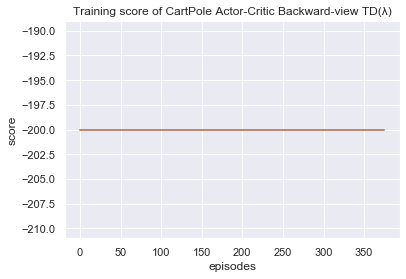

In [10]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole Actor-Critic Backward-view TD(λ)')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [13]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action, lp = select_action(policy_network, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

KeyboardInterrupt: 

In [14]:
env.close()

In [12]:
np.array(scores).mean()

-200.0